# Neural Machine Translation for Cantonese-English Language Pair
Florence Yuen
- Uses datasets from Tatoeba and OpenSubtitles to load Cantonese-English language pair data
- Preprocess character-based and Jyutping romanized Cantonese data by tokenizing and doing data cleansing
- Apply mBART-50 pre-trained multilingual NMT model
- Compare and evaluate greedy and beam search decoding strategies
- Save translation outputs to csv file
- Generates BLEU scores to evaluate and compare the two decoding strategies


In [ ]:
# Install dependencies
%pip install -r requirements.txt

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 38.6 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 31.7 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 7.0/7.0 MB 48.0 MB/s  0:00:00

   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----------- ---------------------------- 2/7 [kiwisolver]
   ----------------- ---------------------- 3/7 [fonttools]
   ----------------- ---------------------- 3/7 [fonttools]
   ----------------- ---------------------- 3/7 [fonttools]
   ----------------- ---------------------- 3/7 [fonttools]
   ----------------- --------------------

## Load Pretrained mBART-50 NMT Model

In [3]:
import torch
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # for progress bar

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer_nllb = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model_nllb = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M").to(device)

In [ ]:
# Models below no longer used due to ineffectivenss of model for Cantonese
# from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# # Import the tokenizer
# model_name = "facebook/mbart-large-50-many-to-many-mmt"
# tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
# model = MBartForConditionalGeneration.from_pretrained(model_name)
# tokenizer.src_lang = "yue_Hant"
# tokenizer.tgt_lang = "en_XX"

# from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

# model_name_m2m = "facebook/m2m100_418M"
# tokenizer_m2m = M2M100Tokenizer.from_pretrained(model_name_m2m)
# model_m2m = M2M100ForConditionalGeneration.from_pretrained(model_name_m2m).to(device)

# Load MarianMT Model
# from transformers import MarianTokenizer, MarianMTModel

# model_name_mar = "Helsinki-NLP/opus-mt-yue-en"
# tokenizer_mar = MarianTokenizer.from_pretrained(model_name_mar)
# model_mar = MarianMTModel.from_pretrained(model_name_mar).to(device)

## Load Dataset from Tatoeba

In [6]:
from datasets import load_dataset
import pandas as pd

In [61]:
import re

# Manually load downloaded .en and .yue files, apply pre-processing to clean the text
def load_parallel_corpus(cantonese_file, english_file, max_lines=None):
    # Open the cantonese and english files
    with open(cantonese_file, encoding='utf-8') as f_yue, open(english_file, encoding='utf-8') as f_en:
        yue_lines = f_yue.readlines()
        en_lines = f_en.readlines()

    # Ensure that there is the same line count
    if max_lines:
        yue_lines = yue_lines[:max_lines]
        en_lines = en_lines[:max_lines]

    assert len(yue_lines) == len(en_lines), "Line count mismatch!"

    #Apply preprocessing to clean the text 
    def clean_text(text):
        # Remove brackets
        text = re.sub(r'\[[^\]]*\]', '', text)
        text = re.sub(r'\([^\)]*\)', '', text)
        
        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    # Clean each line of text for both cantonese and english files
    yue_lines = [clean_text(line) for line in yue_lines]
    en_lines = [clean_text(line) for line in en_lines]

    # Build the DataFrame and drop empty lines
    df = pd.DataFrame({'cantonese': yue_lines, 'english': en_lines})
    df = df[(df['cantonese'] != '') & (df['english'] != '')].reset_index(drop=True)
    return df

def load_all_datasets(model_name):
    dataframes={}
    files = [
        {
            "dataset_name": "Tatoeba",
            "cantonese_file": 'en-yue.txt/Tatoeba.en-yue.yue',
            "english_file": 'en-yue.txt/Tatoeba.en-yue.en'
        },
        {
            "dataset_name": "Open_Subtitles",
            "cantonese_file": 'open-subtitles_en-yue.txt/OpenSubtitles.en-yue.yue',
            "english_file": 'open-subtitles_en-yue.txt/OpenSubtitles.en-yue.en'
        }
    ]
    
    max_lines=1000
    for dataset in files:
        df = load_parallel_corpus(cantonese_file=dataset["cantonese_file"], english_file=dataset["english_file"], max_lines=max_lines)
        df_name = f"{model_name}_{dataset['dataset_name']}"
        dataframes[df_name] = df
    return dataframes

In [8]:
# # Load Tatoeba dataset
df = load_parallel_corpus('en-yue.txt/Tatoeba.en-yue.yue', 'en-yue.txt/Tatoeba.en-yue.en', max_lines=1000)
print(df.head())

             cantonese                                        english
0              我要去瞓覺喇。                         I have to go to sleep.
1  我話唔定做一陣就會放棄，走去瞓晏覺算。       I may give up soon and just nap instead.
2       我不嬲都鍾意啲神秘啲嘅人物。     I always liked mysterious characters more.
3   雖然佢講咗對唔住，但係我都仲係好嬲。  Even though he apologized, I'm still furious.
4               我唯有係等。                               I can only wait.


In [9]:
# Load 1000 lines from OpenSubtitles dataset (downloaded from Opus)
df_Open_Subtitles = load_parallel_corpus('open-subtitles_en-yue.txt/OpenSubtitles.en-yue.yue', 'open-subtitles_en-yue.txt/OpenSubtitles.en-yue.en', max_lines=1000)
print(df_Open_Subtitles.head())

        cantonese                                            english
0              你看                                              Look.
1            笑死我了                                 - That kills me. -
2  來整蠱他吧,讓他見識最佳拍檔  Come on, we'll fix him. Let's give him the old...
3        你還不會用腦嗎?                            Won't you ever grow up?
4              喂喂                                 - What? - Yoo-hoo!


## Define Translation Function

In [45]:
# Translation function with tydm to add a loading progress bar for insights using mBART50 model
def translate(texts, beam=1, batch_size=16):
    translations = []
    # Evaluate the model
    model.eval()
    
    # Devide into batches so that the progress/ percentage is shown too
    for i in tqdm(range(0, len(texts), batch_size), desc="Translating"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                max_length=128,
                num_beams=beam,
                no_repeat_ngram_size=2
            )
        batch_translations = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        translations.extend(batch_translations)
    return translations

# Translation function with model and tokenizer being passed in
def translate_select_model(texts, tokenizer, model, beam=1, batch_size=16, device="cpu", src_lang=None, tgt_lang=None):
    translations = []
    model.to(device)
    model.eval()

    if src_lang:
        tokenizer.src_lang = src_lang # set source language to cantonese
    
    forced_bos_token_id = None
    if tgt_lang:
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),

    
    for i in tqdm(range(0, len(texts), batch_size), desc="Translating"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                forced_bos_token_id = forced_bos_token_id,
                # forced_bos_token_id=tokenizer.get_lang_id("en"),  # Force target language to English
                max_length=128,
                num_beams=beam,
                no_repeat_ngram_size=2
            )
        batch_translations = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        translations.extend(batch_translations)
        if i==0:
            print(f"Initial translations: {batch_translations}")
    return translations



## Translate & Compare Decoding Methods

In [ ]:
# Setup NLLB translation
def translate_nllb(beam=1):
    translate_select_model(
        df_nllb_7['NLLB_7_Open_Subtitles']['cantonese'].tolist(), 
        tokenizer_nllb, model_nllb, 
        beam=beam, batch_size=16, 
        device=device, 
        src_lang="yue_Hant", 
        tgt_lang= "eng_Latn"
    )
    
# Run translations for greedy and beam search algorithm using Tatoeba dataset
df_nllb_7 = load_all_datasets("NLLB_7")

# beam size of 7
print(df_nllb_7)

{'NLLB_7_Tatoeba':                cantonese                                            english
0                我要去瞓覺喇。                             I have to go to sleep.
1    我話唔定做一陣就會放棄，走去瞓晏覺算。           I may give up soon and just nap instead.
2         我不嬲都鍾意啲神秘啲嘅人物。         I always liked mysterious characters more.
3     雖然佢講咗對唔住，但係我都仲係好嬲。      Even though he apologized, I'm still furious.
4                 我唯有係等。                                   I can only wait.
..                   ...                                                ...
995            呢件外套無衫袋㗎。                          This coat hasn't pockets.
996     呢隻蛋糕真係冇啲人講到咁好食囉。  This cake doesn't really live up to its reputa...
997        呢條規則唔係幾時都啱用㗎。             This rule doesn't apply to every case.
998           呢部相機冇嗰部咁貴。       This camera is less expensive than that one.
999   你可唔可以用呢部相機幫我哋影幅相呀？   Would you take a picture of us with this camera?

[1000 rows x 2 columns], 'NLLB_7_Open_Subtitles':           cantones

In [87]:
df_nllb_3 = load_all_datasets("NLLB_3")
df_nllb_3['NLLB_3_Open_Subtitles']['beam'] = translate_nllb(beam=3)
df_nllb_3['NLLB_3_Tatoeba']['beam'] = translate_nllb(beam=3)

Translating:   2%|▏         | 1/62 [00:11<11:55, 11.74s/it]

Initial translations: ['You see.', 'It made me laugh.', "Let's fix him up and show him the best shot.", "You're not going to use your brain?", 'Oh, my God.', 'Give it to me.', 'Get out of the way.', 'A self-righteous asshole.', "That's good.", 'See you again.', 'I got you, you little bastards, get out of here.', "Don't ever come back.", "Hey, what's going on?", 'Okay, hold your hands, you... shoot him, and continue the war plan.', 'Come on now.', 'Let me wait for you...']


Translating:   2%|▏         | 1/62 [00:13<13:15, 13.04s/it]

Initial translations: ['You see.', 'It made me laugh.', "Let's fix him up and show him the best shot.", "You're not going to use your brain?", 'Oh, my God.', 'Give it to me.', 'Get out of the way.', 'A self-righteous asshole.', "That's good.", 'See you again.', 'I got you, you little bastards, get out of here.', "Don't ever come back.", "Hey, what's going on?", 'Okay, hold your hands, you... shoot him, and continue the war plan.', 'Come on now.', 'Let me wait for you...']


Translating: 100%|██████████| 62/62 [13:48<00:00, 13.37s/it]


In [85]:
df_nllb_7['NLLB_7_Open_Subtitles']['beam'] = translate_nllb(beam=7)
df_nllb_7['NLLB_7_Open_Subtitles'].head()

Translating:   0%|          | 0/62 [00:00<?, ?it/s]

Translating:   2%|▏         | 1/62 [00:27<28:19, 27.86s/it]

Initial translations: ['You see.', 'It made me laugh.', "Let's fix him up and show him the best shot.", "Aren't you going to use your brain?", 'Oh, my God.', 'Give it to me.', 'Get out of the way.', 'A self-righteous asshole.', "That's good.", 'See you again.', 'Get it, you little bastards, get out of here.', "Don't ever come back.", "Hey, what's going on?", 'Hey, hold your hands, you... shoot him and keep planning the war.', 'Come on now.', 'Let me wait for you...']


Translating: 100%|██████████| 62/62 [32:15<00:00, 31.22s/it]


,cantonese,english,beam
0,你看,Look.,None
1,笑死我了,- That kills me. -,None
2,"來整蠱他吧,讓他見識最佳拍檔","Come on, we'll fix him. Let's give him the old...",None
3,你還不會用腦嗎?,Won't you ever grow up?,None
4,喂喂,- What? - Yoo-hoo!,None


In [ ]:
df_nllb_10 = load_all_datasets("NLLB_10")
df_nllb_10['NLLB_10_Open_Subtitles']['beam'] = translate_nllb(beam=10)
df_nllb_10['NLLB_10_Open_Subtitles'].head()

Translating:   2%|▏         | 1/62 [00:42<43:17, 42.59s/it]

Initial translations: ['You see.', 'It made me laugh.', "Let's fix him up and show him the best shot.", "Aren't you going to use your brain?", 'Oh, my God.', 'Give it to me.', "Let's get out of here.", 'A self-proclaimed smart guy.', "That's good.", 'See you again.', 'Got it, you little assholes, get out of here.', "Don't ever come back.", "Hey, what's going on?", 'Hey, hold your hands, you... shoot him and keep planning the war.', 'Come on now.', 'Let me wait for you...']


Translating: 100%|██████████| 62/62 [45:30<00:00, 44.04s/it]


,cantonese,english,beam
0,你看,Look.,None
1,笑死我了,- That kills me. -,None
2,"來整蠱他吧,讓他見識最佳拍檔","Come on, we'll fix him. Let's give him the old...",None
3,你還不會用腦嗎?,Won't you ever grow up?,None
4,喂喂,- What? - Yoo-hoo!,None


In [102]:
df_nllb_15 = load_all_datasets("NLLB_15")
df_nllb_15['NLLB_15_Open_Subtitles']['beam'] = translate_nllb(beam=15)
df_nllb_15['NLLB_15_Open_Subtitles'].head()

Translating:   2%|▏         | 1/62 [01:21<1:22:59, 81.63s/it]

Initial translations: ['You see.', 'It made me laugh.', "Let's get him cleaned up and show him the best shot.", "Aren't you going to use your brain?", 'Oh, my God.', 'Give it to me.', 'Get out of the way, turn around.', 'A self-proclaimed smart guy.', "That's good.", 'See you again.', 'Got it, you little bastards, get out of here.', "Don't ever come back.", "Hey, what's going on?", 'Hey, hold your hands, you... shoot him and keep planning the war.', 'Come on now.', 'Let me wait for you...']


Translating: 100%|██████████| 62/62 [1:06:02<00:00, 63.91s/it]


,cantonese,english,beam
0,你看,Look.,None
1,笑死我了,- That kills me. -,None
2,"來整蠱他吧,讓他見識最佳拍檔","Come on, we'll fix him. Let's give him the old...",None
3,你還不會用腦嗎?,Won't you ever grow up?,None
4,喂喂,- What? - Yoo-hoo!,None


In [84]:
df_nllb_10['NLLB_10_Open_Subtitles']['greedy'] = translate_nllb(beam=10)

Translating:   2%|▏         | 1/62 [00:35<36:22, 35.78s/it]

Initial translations: ['You see.', 'It made me laugh.', "Let's fix him up and show him the best shot.", "Aren't you going to use your brain?", 'Oh, my God.', 'Give it to me.', "Let's get out of here.", 'A self-proclaimed smart guy.', "That's good.", 'See you again.', 'Got it, you little assholes, get out of here.', "Don't ever come back.", "Hey, what's going on?", 'Hey, hold your hands, you... shoot him and keep planning the war.', 'Come on now.', 'Let me wait for you...']


Translating: 100%|██████████| 62/62 [44:13<00:00, 42.80s/it]


In [14]:
# Run using M2M
df_m2m = load_parallel_corpus('en-yue.txt/Tatoeba.en-yue.yue', 'en-yue.txt/Tatoeba.en-yue.en', max_lines=1000)
print(df_m2m.head())

df_m2m['greedy'] = translate_select_model(df_m2m['cantonese'].tolist(), tokenizer_m2m, model_m2m, beam=1, batch_size=16, device=device)
df_m2m['beam'] = translate_select_model(df_m2m['cantonese'].tolist(), tokenizer_m2m, model_m2m, beam=5, batch_size=16, device=device)
df_m2m.head()

             cantonese                                        english
0              我要去瞓覺喇。                         I have to go to sleep.
1  我話唔定做一陣就會放棄，走去瞓晏覺算。       I may give up soon and just nap instead.
2       我不嬲都鍾意啲神秘啲嘅人物。     I always liked mysterious characters more.
3   雖然佢講咗對唔住，但係我都仲係好嬲。  Even though he apologized, I'm still furious.
4               我唯有係等。                               I can only wait.


Translating: 100%|██████████| 63/63 [38:20<00:00, 36.51s/it] 


,cantonese,english,greedy,beam
0,我要去瞓覺喇。,I have to go to sleep.,Менің қазір мен қасымда.,Өзiмiкiнiгiпiң кiлiшiрi.
1,我話唔定做一陣就會放棄，走去瞓晏覺算。,I may give up soon and just nap instead.,"Менің қазір, қаңтар мен қазыққа қазанды, менің...","Қандай-ақ, қанақтар мен ұзақ уақытқа дейін қар..."
2,我不嬲都鍾意啲神秘啲嘅人物。,I always liked mysterious characters more.,Менің табылған тазалық тазыққа не айтылады.,Je n’ai pas l’intention de connaître les perso...
3,雖然佢講咗對唔住，但係我都仲係好嬲。,"Even though he apologized, I'm still furious.",Менің қазір мен қаңтар менің жарыққа қадам.,"Қандай-ақ, қазір мен қағидалар мен жарықтармен..."
4,我唯有係等。,I can only wait.,Менің қазір мен қасым.,Je n’ai qu’à attendre.


In [46]:
# Run using M2M
df_nllb = load_parallel_corpus('en-yue.txt/Tatoeba.en-yue.yue', 'en-yue.txt/Tatoeba.en-yue.en', max_lines=1000)
print(df_nllb.head())

df_nllb['greedy'] = translate_select_model(df_nllb['cantonese'].tolist(), tokenizer_nllb, model_nllb, beam=1, batch_size=16, device=device, src_lang="yue_Hant", tgt_lang= "eng_Latn")
df_nllb.head()

             cantonese                                        english
0              我要去瞓覺喇。                         I have to go to sleep.
1  我話唔定做一陣就會放棄，走去瞓晏覺算。       I may give up soon and just nap instead.
2       我不嬲都鍾意啲神秘啲嘅人物。     I always liked mysterious characters more.
3   雖然佢講咗對唔住，但係我都仲係好嬲。  Even though he apologized, I'm still furious.
4               我唯有係等。                               I can only wait.


Translating:   2%|▏         | 1/63 [00:11<11:49, 11.44s/it]

Initial translations: ['I have to go to bed.', 'I said, "I\'m going to give up and go to bed".', 'I like mysterious characters.', 'She apologized, but I was still a little bit of a bitch.', 'I was just waiting.', 'I love you.', 'It will land on the moon tomorrow.', "It'll land on the moon tomorrow.", '"Honestly, I\'m scared of being high". "No more cowards!"', '"The phone rings". "I hear you".', '"Thank you for your help". "No, thank you".', '"What are you doing wrong?" "Because I don\'t want to go to the bathroom".', "Democracy is the worst political system, except for the ones we've tried.", "Oh, that's good to see you!", 'Can you speak Italian?', 'Do you have a condom?']


Translating: 100%|██████████| 63/63 [07:14<00:00,  6.89s/it]


,cantonese,english,greedy
0,我要去瞓覺喇。,I have to go to sleep.,I have to go to bed.
1,我話唔定做一陣就會放棄，走去瞓晏覺算。,I may give up soon and just nap instead.,"I said, ""I'm going to give up and go to bed""."
2,我不嬲都鍾意啲神秘啲嘅人物。,I always liked mysterious characters more.,I like mysterious characters.
3,雖然佢講咗對唔住，但係我都仲係好嬲。,"Even though he apologized, I'm still furious.","She apologized, but I was still a little bit o..."
4,我唯有係等。,I can only wait.,I was just waiting.


In [47]:
df_nllb['beam'] = translate_select_model(df_nllb['cantonese'].tolist(), tokenizer_nllb, model_nllb, beam=5, batch_size=16, device=device, src_lang="yue_Hant", tgt_lang="eng_Latn")

Translating:   2%|▏         | 1/63 [00:27<28:20, 27.43s/it]

Initial translations: ['I have to go to bed.', "I told him I'd give up and go to bed.", 'I like more mysterious characters.', 'She apologized, but I was fine.', 'I was just waiting.', 'I love you.', 'It will land on the moon tomorrow.', 'It will land on the moon tomorrow.', '"Honestly, I\'m really scared". "Don\'t be a coward!"', '"The phone rings". "I hear you".', '"Thank you very much". "No, thank you".', '"What are you not doing?" "Because I don\'t want to go".', "Democracy is the worst political system I've ever tried.", 'Oh, good to see you!', 'Can you speak Italian?', 'Do you have a condom?']


Translating: 100%|██████████| 63/63 [25:26<00:00, 24.22s/it]


In [53]:
# Run using M2M
df_nllb_os = load_parallel_corpus('open-subtitles_en-yue.txt/OpenSubtitles.en-yue.yue', 'open-subtitles_en-yue.txt/OpenSubtitles.en-yue.en', max_lines=1000)
print(df_nllb_os.head())

df_nllb_os['greedy'] = translate_select_model(df_nllb_os['cantonese'].tolist(), tokenizer_nllb, model_nllb, beam=1, batch_size=16, device=device, src_lang="yue_Hant", tgt_lang= "eng_Latn")
df_nllb_os.head()

        cantonese                                            english
0              你看                                              Look.
1            笑死我了                                 - That kills me. -
2  來整蠱他吧,讓他見識最佳拍檔  Come on, we'll fix him. Let's give him the old...
3        你還不會用腦嗎?                            Won't you ever grow up?
4              喂喂                                 - What? - Yoo-hoo!


Translating:   2%|▏         | 1/62 [00:05<05:12,  5.13s/it]

Initial translations: ['You see.', 'It made me laugh.', 'Get him a job and let him see the best shot.', "You're not going to use your brain?", 'Oh, my God.', 'Give me a round.', 'Go ahead and roll.', 'A self-righteous asshole.', "That's good.", 'See you again.', 'Get it, you little bastards, get out of here.', 'Never come back.', 'What are we doing?', 'Hold your hands, you... shoot him and keep planning the war.', 'Come on, you know.', 'Let me wait for you...']


Translating: 100%|██████████| 62/62 [07:05<00:00,  6.87s/it]


,cantonese,english,greedy
0,你看,Look.,You see.
1,笑死我了,- That kills me. -,It made me laugh.
2,"來整蠱他吧,讓他見識最佳拍檔","Come on, we'll fix him. Let's give him the old...",Get him a job and let him see the best shot.
3,你還不會用腦嗎?,Won't you ever grow up?,You're not going to use your brain?
4,喂喂,- What? - Yoo-hoo!,"Oh, my God."


In [54]:
# run beam search using nllb model on Open Subtitles dataset
df_nllb_os['beam'] = translate_select_model(df_nllb_os['cantonese'].tolist(), tokenizer_nllb, model_nllb, beam=5, batch_size=16, device=device, src_lang="yue_Hant", tgt_lang="eng_Latn")

Translating:   2%|▏         | 1/62 [00:23<23:44, 23.36s/it]

Initial translations: ['You see.', 'It made me laugh.', "Let's fix him up and show him the best shot.", "Aren't you going to use your brain?", 'Oh, my God.', 'Give it to me.', 'Get out of the way.', 'A self-righteous asshole.', "That's good.", 'See you again.', 'Get it, you little assholes, get out of here.', "Don't ever come back.", "Hey, what's going on?", 'Okay, hold your hands, you... shoot him, and continue the war plan.', 'Come on now.', 'Let me wait for you...']


Translating: 100%|██████████| 62/62 [27:16<00:00, 26.39s/it]


In [79]:
from sacrebleu import corpus_bleu
from sacrebleu import corpus_chrf

# Function to loop over all  dataframes defined and print out BLEU and CHRF scores
def compute_scores(df, name="", use_greedy=True, use_beam=True):
    greedy_bleu, greedy_chrf, beam_bleu, beam_chrf = None, None, None, None
    references = [df['english'].astype(str).tolist()]

    if use_greedy:
        # Prepare hypothesis and reference lists
        greedy_hypotheses = df['greedy'].astype(str).tolist()
        # Compute BLEU scores
        greedy_bleu = corpus_bleu(greedy_hypotheses, references).score
        greedy_chrf = corpus_chrf(greedy_hypotheses, references).score

    if use_beam:
        beam_hypotheses = df['beam'].astype(str).tolist()
        beam_bleu = corpus_bleu(beam_hypotheses, references).score
        beam_chrf = corpus_chrf(beam_hypotheses, references).score

    # Print results
    print(f"{name} BLEU Scores:")
    if use_greedy:
        print(f"Greedy BLEU: {greedy_bleu:.2f}")
    if use_beam:
        print(f"Beam BLEU:   {beam_bleu:.2f}")
    
    print(f"\n{name} CHRF Scores:")
    if use_greedy:
        print(f"Greedy CHRF: {greedy_chrf:.2f}")
    if use_beam:
        print(f"BEAM CHRF: {beam_chrf:.2f}")
    
    return greedy_bleu, beam_bleu, greedy_chrf, beam_chrf


In [18]:
results_m2m = {}
name = "m2m"
print(f"Evaluating name: {name}")
greedy_bleu, beam_bleu, greedy_chrf, beam_chrf = compute_scores(df_m2m, name)
results_m2m[name] = {"greedy_bleu": greedy_bleu, "beam_bleu": beam_bleu, "greedy_chrf": greedy_chrf, "beam_chrf": beam_chrf}
df_m2m.to_csv(f"trans_res_{name}.csv", index=False)

Evaluating name: m2m

m2m BLEU Scores:
Greedy BLEU: 0.07
Beam BLEU:   0.07

m2m CHRF Scores:
Greedy CHRF: 3.96
BEAM CHRF: 5.22


In [20]:
# Run using M2M on OpenSubtitles dataset
df_Open_Subtitles['greedy'] = translate_select_model(df_Open_Subtitles['cantonese'].tolist(), tokenizer_m2m, model_m2m, beam=1, batch_size=16, device=device)

Translating:   0%|          | 0/62 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [31]:
df_Open_Subtitles['beam'] = translate_select_model(df_Open_Subtitles['cantonese'].tolist(), tokenizer_m2m, model_m2m, beam=5, batch_size=16, device=device)

KeyError: 'yue'

In [29]:
greedy_bleu, beam_bleu, greedy_chrf, beam_chrf = compute_scores(df=df_Open_Subtitles, name=name, use_beam=False)


m2m BLEU Scores:
Greedy BLEU: 0.56

m2m CHRF Scores:
Greedy CHRF: 10.44


In [ ]:
# Run translations for greedy and beam search algorithm using OpenSubtitles dataset
df_OS_mBART = load_parallel_corpus('open-subtitles_en-yue.txt/OpenSubtitles.en-yue.yue', 'open-subtitles_en-yue.txt/OpenSubtitles.en-yue.en', max_lines=1000)
print(df_OS_mBART.head())
df_OS_mBART['greedy'] = translate(df_OS_mBART['cantonese'].tolist(), beam=1, batch_size=16)
df_OS_mBART['beam'] = translate(df_OS_mBART['cantonese'].tolist(), beam=5, batch_size=16)
df_OS_mBART.head()

In [ ]:
# # Run using MarianMT on Tatoeba dataset
# df_Tatoeba = load_parallel_corpus('en-yue.txt/Tatoeba.en-yue.yue', 'en-yue.txt/Tatoeba.en-yue.en', max_lines=1000)
# print(df_Tatoeba.head())

# df_Tatoeba['greedy'] = translate(df_Tatoeba['cantonese'].tolist(), tokenizer_mar, model_mar, beam=1, batch_size=16, device=device)
# df_Tatoeba['beam'] = translate(df_Tatoeba['cantonese'].tolist(), tokenizer_mar, model_mar, beam=5, batch_size=16, device=device)
# df_Tatoeba.head()

In [ ]:
# Run using MarianMT on OpenSubtitles dataset
df_OS_Mar = load_parallel_corpus('open-subtitles_en-yue.txt/OpenSubtitles.en-yue.yue', 'open-subtitles_en-yue.txt/OpenSubtitles.en-yue.en', max_lines=1000)
print(df_OS_Mar.head())

df_OS_Mar['greedy'] = translate(df_OS_Mar['cantonese'].tolist(), tokenizer_mar, model_mar, beam=1, batch_size=16, device=device)
df_OS_Mar['beam'] = translate(df_OS_Mar['cantonese'].tolist(), tokenizer_mar, model_mar, beam=5, batch_size=16, device=device)

        cantonese                                            english
0              你看                                              Look.
1            笑死我了                                 - That kills me. -
2  來整蠱他吧,讓他見識最佳拍檔  Come on, we'll fix him. Let's give him the old...
3        你還不會用腦嗎?                            Won't you ever grow up?
4              喂喂                                 - What? - Yoo-hoo!


NameError: name 'tokenizer_mar' is not defined

## Evaluate algorithms using BLEU scores

In [ ]:
from sacrebleu import corpus_bleu

# Define hypotheses for greedy and beam search (as string lists)
greedy_hypotheses = df['greedy'].astype(str).tolist()
beam_hypotheses = df['beam'].astype(str).tolist()

# Define references as string lists
references = [df['english'].astype(str).tolist()]

# Calculate the bleu score
greedy_bleu = corpus_bleu(greedy_hypotheses, references).score
beam_bleu = corpus_bleu(beam_hypotheses, references).score

# Display bleu score
print(f"Greedy BLEU: {greedy_bleu:.2f}")
print(f"Beam BLEU: {beam_bleu:.2f}")


Greedy BLEU: 7.94
Beam BLEU: 9.21


In [103]:
# Define a list of (name, dataframe) pairs
use_beam = True
use_greedy = True
dataframes = [
    # ("Tatoeba + mBART", df),
    # ("Open Subtitles_mBART", df_OS_mBART),
    ("Tatoeba_NLLB", df_nllb, use_greedy ), # beam = 5, greedy = 1
    ("OpenSubtitles_NLLB", df_nllb_os, use_greedy), # beam = 5, greedy = 1
    ("NLLB_7_Open_Subtitles", df_nllb_7['NLLB_7_Open_Subtitles'], False), # beam = 7
    ("Tatoeba_m2m", df_m2m, use_greedy), # beam = n/a
    ("OpenSubtitles_m2m", df_Open_Subtitles, use_greedy), # n/a
    ("NLLB_3_Tatoeba", df_nllb_3['NLLB_3_Tatoeba'], False), # n/a
    ("NLLB_3_Open_Subtitles", df_nllb_3['NLLB_3_Open_Subtitles'], False), # beam = 3
    ("NLLB_15_Tatoeba", df_nllb_15['NLLB_15_Tatoeba'], False), # n/a
    ("NLLB_15_Open_Subtitles", df_nllb_15['NLLB_15_Open_Subtitles'], False), # beam = 15
    # ("NLLB_7_Tatoeba", df_nllb_7['NLLB_7_Open_Tatoeba']),
    
]


# Compute BLEU and CHRF scores for each DataFrame
results = {}
scores = {
    "beam_size": [],
    "BLEU": [],
    "chrf": []
}

# Calculate BLEU and CHRF scores for each of the data frames and save to list
for name, df_, use_greedy in dataframes:
    try:
        print(f"Evaluating name: {name}, {use_greedy}")
        greedy_bleu, beam_bleu, greedy_chrf, beam_chrf = compute_scores(df_, name, use_greedy = use_greedy)
        results[name] = {"greedy_bleu": greedy_bleu, "beam_bleu": beam_bleu, "greedy_chrf": greedy_chrf, "beam_chrf": beam_chrf}
        df_.to_csv(f"trans_res_{name}.csv", index=False)
        print("-------")
    except Exception as e:
        print(f"Error evaluating {name}: {e}")


Evaluating name: Tatoeba_NLLB, True
Tatoeba_NLLB BLEU Scores:
Greedy BLEU: 24.62
Beam BLEU:   24.79

Tatoeba_NLLB CHRF Scores:
Greedy CHRF: 43.91
BEAM CHRF: 44.18
-------
Evaluating name: OpenSubtitles_NLLB, True
OpenSubtitles_NLLB BLEU Scores:
Greedy BLEU: 14.80
Beam BLEU:   15.54

OpenSubtitles_NLLB CHRF Scores:
Greedy CHRF: 34.10
BEAM CHRF: 34.75
-------
Evaluating name: NLLB_7_Open_Subtitles, False
NLLB_7_Open_Subtitles BLEU Scores:
Beam BLEU:   0.00

NLLB_7_Open_Subtitles CHRF Scores:
BEAM CHRF: 2.95
-------
Evaluating name: Tatoeba_m2m, True
Tatoeba_m2m BLEU Scores:
Greedy BLEU: 0.07
Beam BLEU:   0.07

Tatoeba_m2m CHRF Scores:
Greedy CHRF: 3.96
BEAM CHRF: 5.22
-------
Evaluating name: OpenSubtitles_m2m, True
Error evaluating OpenSubtitles_m2m: 'beam'
Evaluating name: NLLB_3_Tatoeba, False
NLLB_3_Tatoeba BLEU Scores:
Beam BLEU:   0.00

NLLB_3_Tatoeba CHRF Scores:
BEAM CHRF: 3.04
-------
Evaluating name: NLLB_3_Open_Subtitles, False
NLLB_3_Open_Subtitles BLEU Scores:
Beam BLEU:   0

## Save Translation Comaprison Results to CSV

In [ ]:
# df.to_csv("trans_res_Tatoeba_mBart.csv", index=False)
# df.head()

,cantonese,english,greedy,beam
0,我要去瞓覺喇。,I have to go to sleep.,I'm going to go to the temple.,I'm going to go to the monastery.
1,我話唔定做一陣就會放棄，走去瞓晏覺算。,I may give up soon and just nap instead.,I'm going to say I will give up a fight and go...,I said I was going to do a series I would give...
2,我不嬲都鍾意啲神秘啲嘅人物。,I always liked mysterious characters more.,I'm not a big fan of mysterious characters.,I don't think I've ever heard of a mysterious ...
3,雖然佢講咗對唔住，但係我都仲係好嬲。,"Even though he apologized, I'm still furious.","I'm not sure if I can do it, but I have a good...","I'm not sure if we're going to live together, ..."
4,我唯有係等。,I can only wait.,I'm only a single one.,I'm the only one who can wait.


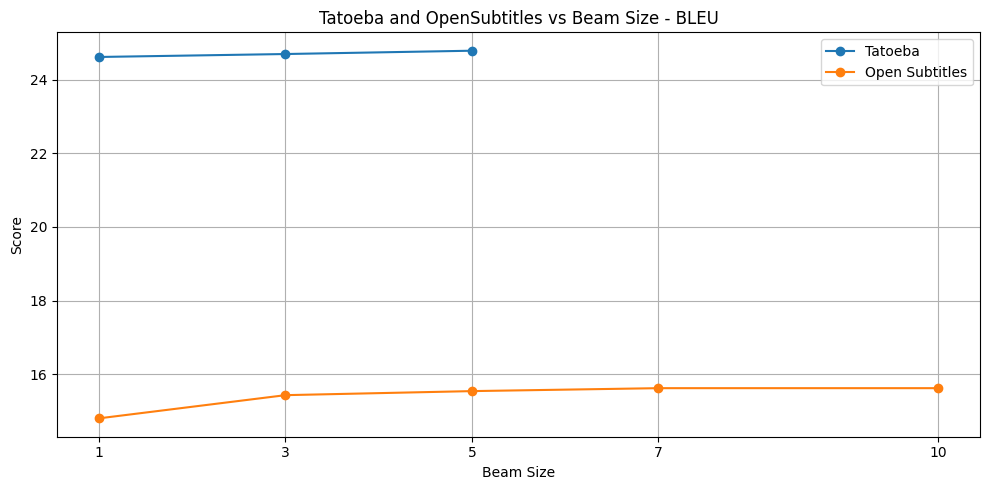

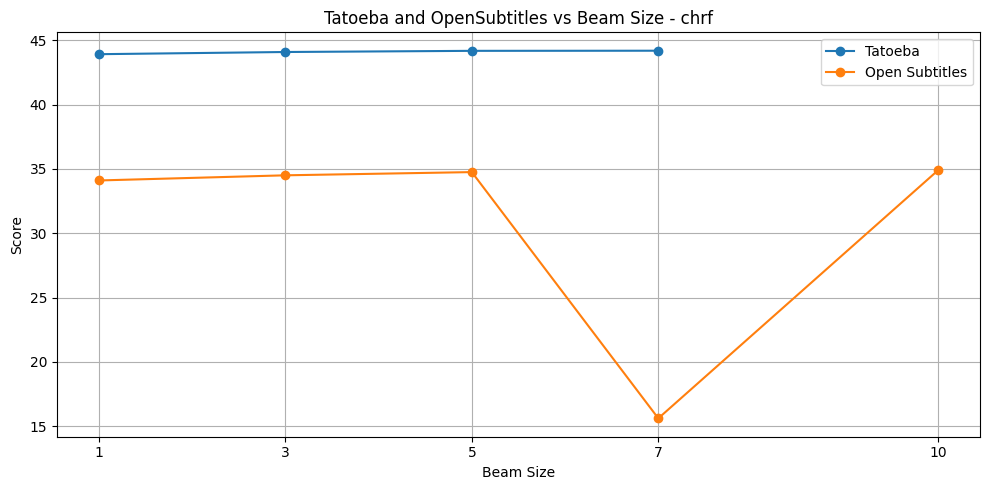

In [101]:
# Plot OpenSubtitles dataset using NLLB model results
import matplotlib.pyplot as plt

beam_sizes = [1, # greedy
              3, 5, 7, 10] # beam search

bleu_tatoeba = [24.62, 24.70, 24.79, None, None]
chrf_tatoeba = [43.91, 44.08, 44.17, 44.18, None]

bleu_opensub = [14.80, 15.43, 15.54, 15.62, 15.62]
chrf_opensub = [34.10, 34.50, 34.75, 15.62, 34.89]

tatoeba_scores = pd.DataFrame({
    "beam_size": beam_sizes,
    "BLEU": bleu_tatoeba,
    "chrf": chrf_tatoeba
})


opensub_scores = pd.DataFrame({
    "beam_size": beam_sizes,
    "BLEU": bleu_opensub,
    "chrf": chrf_opensub
})
def plot_scores(metric):
    plt.figure(figsize=(10,5))

    plt.plot(beam_sizes, tatoeba_scores[metric], marker="o", label="Tatoeba")
    plt.plot(beam_sizes, opensub_scores[metric], marker="o", label="Open Subtitles")

    plt.xlabel("Beam Size")
    plt.ylabel("Score")
    plt.title(f"Tatoeba and OpenSubtitles vs Beam Size - {metric}")
    plt.xticks(beam_sizes)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_scores_dataset(score_df, dataset_name):
    plt.figure(figsize=(10,5))

    plt.plot(score_df["beam_size"], score_df["BLEU"], marker="o", label="BLEU")
    plt.plot(score_df["beam_size"], score_df["chrf"], marker="o", label="chrf")

    plt.xlabel("Beam Size")
    plt.ylabel("Score")
    plt.title(f"BLEU and chrf vs Beam Size - {dataset_name}")
    plt.xticks(score_df["beam_size"])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_scores("BLEU")
plot_scores("chrf")